EnbPI, with no partial_fit, width optimization
EnbPI with partial_fit, width optimization
Coverage / prediction interval width mean for MapieTimeSeriesRegressor: 
EnbPI without any partial_fit:1.000, 0.616
Coverage / prediction interval width mean for MapieTimeSeriesRegressor: 
EnbPI with partial_fit:1.000, 0.601


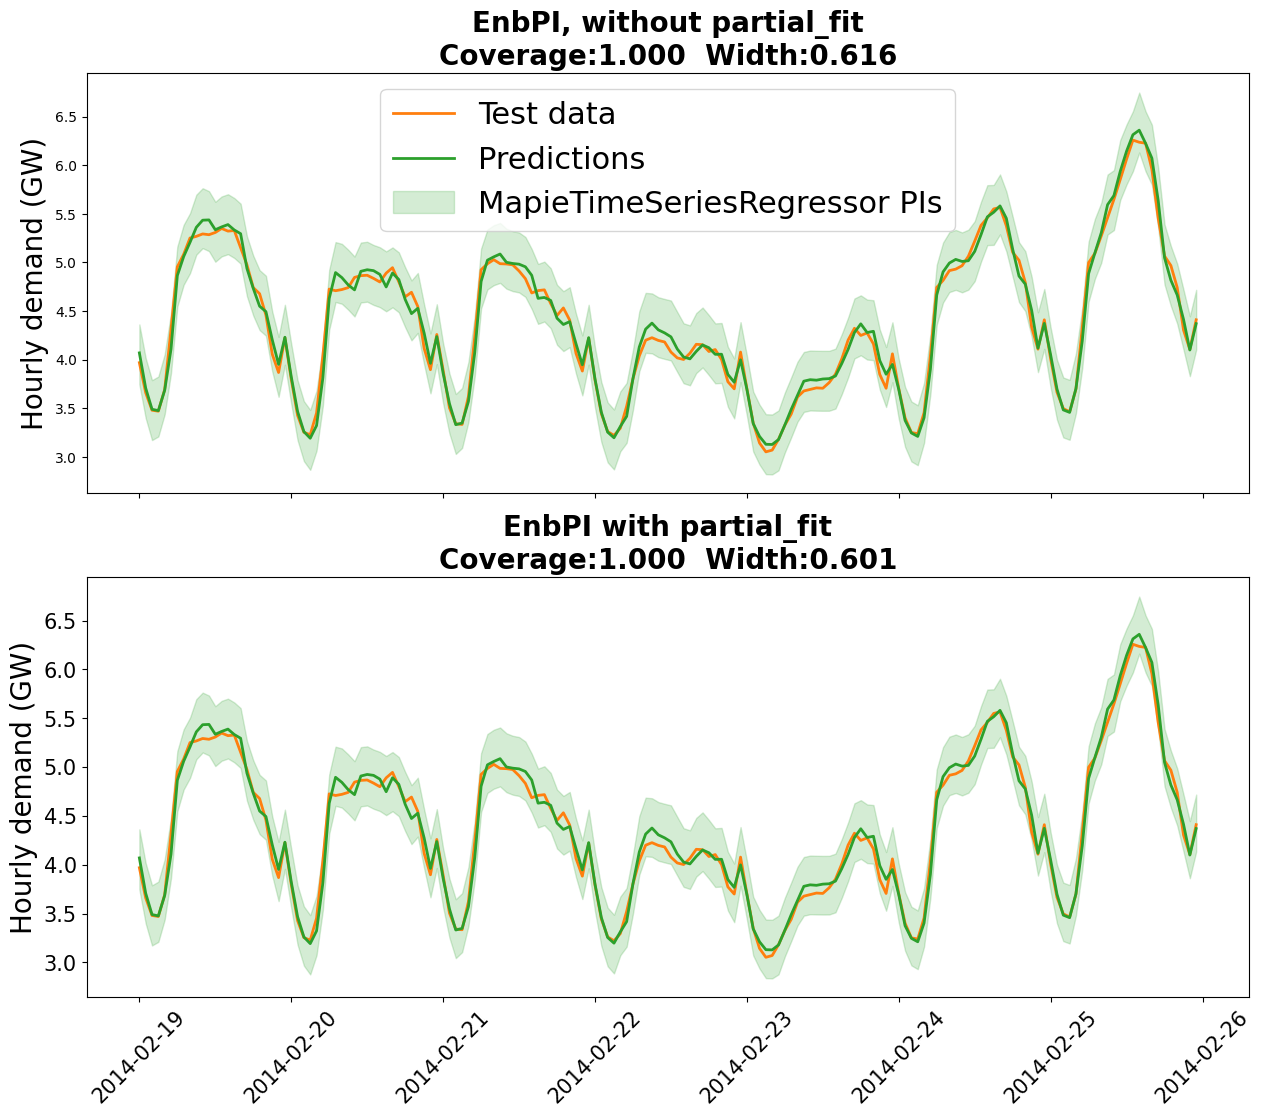

In [1]:
import warnings
from typing import cast

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie._typing import NDArray
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap

warnings.simplefilter("ignore")


# Load input data and feature engineering
url_file = (
    "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/"
    + "master/examples/data/demand_temperature.csv"
)
demand_df = pd.read_csv(url_file, parse_dates=True, index_col=0)

demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)

# Train/validation/test split
num_test_steps = 24 * 7
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour", "Temperature"] + [
    f"Lag_{hour}" for hour in range(1, n_lags)
]

X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
y_train = demand_train.loc[X_train.index, "Demand"]
X_test = demand_test.loc[:, features]
y_test = demand_test["Demand"]

perform_hyperparameters_search = False
if perform_hyperparameters_search:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59
    )

# Estimate prediction intervals on test set with best estimator
alpha = 0.05
cv_mapietimeseries = BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)

mapie_enpbi = MapieTimeSeriesRegressor(
    model,
    method="enbpi",
    cv=cv_mapietimeseries,
    agg_function="mean",
    n_jobs=-1,
)

print("EnbPI, with no partial_fit, width optimization")
mapie_enpbi = mapie_enpbi.fit(X_train, y_train)
y_pred_npfit_enbpi, y_pis_npfit_enbpi = mapie_enpbi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit_enbpi = regression_coverage_score(
    y_test, y_pis_npfit_enbpi[:, 0, 0], y_pis_npfit_enbpi[:, 1, 0]
)

width_npfit_enbpi = regression_mean_width_score(
    y_pis_npfit_enbpi[:, 1, 0], y_pis_npfit_enbpi[:, 0, 0]
)

print("EnbPI with partial_fit, width optimization")
mapie_enpbi = mapie_enpbi.fit(X_train, y_train)
y_pred_pfit_enbpi = np.zeros(y_pred_npfit_enbpi.shape)
y_pis_pfit_enbpi = np.zeros(y_pis_npfit_enbpi.shape)

step_size = 1
(
    y_pred_pfit_enbpi[:step_size],
    y_pis_pfit_enbpi[:step_size, :, :],
) = mapie_enpbi.predict(
    X_test.iloc[:step_size, :], alpha=alpha, ensemble=True, optimize_beta=True
)

for step in range(step_size, len(X_test), step_size):
    mapie_enpbi.partial_fit(
        X_test.iloc[(step - step_size):step, :],
        y_test.iloc[(step - step_size):step],
    )
    (
        y_pred_pfit_enbpi[step:step + step_size],
        y_pis_pfit_enbpi[step:step + step_size, :, :],
    ) = mapie_enpbi.predict(
        X_test.iloc[step:(step + step_size), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
    )
coverage_pfit_enbpi = regression_coverage_score(
    y_test, y_pis_pfit_enbpi[:, 0, 0], y_pis_pfit_enbpi[:, 1, 0]
)
width_pfit_enbpi = regression_mean_width_score(
    y_pis_pfit_enbpi[:, 1, 0], y_pis_pfit_enbpi[:, 0, 0]
)

# Print results
print(
    "Coverage / prediction interval width mean for MapieTimeSeriesRegressor: "
    "\nEnbPI without any partial_fit:"
    f"{coverage_npfit_enbpi:.3f}, {width_npfit_enbpi:.3f}"
)
print(
    "Coverage / prediction interval width mean for MapieTimeSeriesRegressor: "
    "\nEnbPI with partial_fit:"
    f"{coverage_pfit_enbpi:.3f}, {width_pfit_enbpi:.3f}"
)

enbpi_no_pfit = {
    "y_pred": y_pred_npfit_enbpi,
    "y_pis": y_pis_npfit_enbpi,
    "coverage": coverage_npfit_enbpi,
    "width": width_npfit_enbpi,
}

enbpi_pfit = {
    "y_pred": y_pred_pfit_enbpi,
    "y_pis": y_pis_pfit_enbpi,
    "coverage": coverage_pfit_enbpi,
    "width": width_pfit_enbpi,
}

results = [enbpi_no_pfit, enbpi_pfit]

# Plot estimated prediction intervals on test set
fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(15, 12), sharex="col"
)

for i, (ax, w, result) in enumerate(
    zip(axs, ["EnbPI, without partial_fit", "EnbPI with partial_fit"], results)
):
    ax.set_ylabel("Hourly demand (GW)", fontsize=20)
    ax.plot(demand_test.Demand, lw=2, label="Test data", c="C1")

    ax.plot(
        demand_test.index,
        result["y_pred"],
        lw=2,
        c="C2",
        label="Predictions",
    )

    y_pis = cast(NDArray, result["y_pis"])

    ax.fill_between(
        demand_test.index,
        y_pis[:, 0, 0],
        y_pis[:, 1, 0],
        color="C2",
        alpha=0.2,
        label="MapieTimeSeriesRegressor PIs",
    )

    ax.set_title(
        w + "\n"
        f"Coverage:{result['coverage']:.3f}  Width:{result['width']:.3f}",
        fontweight="bold",
        size=20
    )
    plt.xticks(size=15, rotation=45)
    plt.yticks(size=15)

axs[0].legend(prop={'size': 22})
plt.show()